# Simulation study for the $t$-statistic
This notebook presents a simulation study for the $t$-statistic for inference on coefficients of normalised basis vectors for invariant subspaces. For more details, see Simons (2023).

In [1]:
using Distributions, Statistics, LinearAlgebra, StatsPlots
mu = [ 0; 0 ]
M2 = [1 -3; -1 1];
cov = [ 1 2 ; 2 3];
c = cov * cov / 100;
#c = I(2);
d = MvNormal(mu,c);
mc_reps = 1500;
sample_size = 100;
p = 2;
q = 1;
r = p-q;
#first dimension of errors is mc_reps and second dimension is sample
errors = [M2 + rand(d,p) for _ in 1:mc_reps, _ in 1:sample_size];
#makes a mc_reps by 1 matrix of matrices
matrix_estimates = mean(errors,dims=(2));



demeaned_matrices = [errors[i,:,:] .- matrix_estimates[i,:,:] for i in 1:mc_reps]

cov_estimates = Array{Float64,3}(undef,mc_reps,p^2,p^2) 
smaller_cov_estimate = Array{Float64}(undef,p,p);
smaller_cov_estimates = Array{Float64,3}(undef,mc_reps,p,p)

for mcrep in 1:mc_reps
    cov_estimate = Array{Float64,2}(undef,p^2,p^2);
    fill!(cov_estimate,0.0);
    for s in 1:sample_size
        cov_estimate += vec(demeaned_matrices[mcrep][s])*vec(demeaned_matrices[mcrep][s])';
    end
    #average across other dimension
    fill!(smaller_cov_estimate,0.0)
    for maus in 1:p
        #1 p+1 2p+1 to p 2p 
        smaller_cov_estimate += cov_estimate[(1+ (maus-1)*p) : (maus*p) , (1+ (maus-1)*p) : (maus*p) ]
    end

    cov_estimates[mcrep,:,:] = cov_estimate / sample_size;
    smaller_cov_estimates[mcrep,:,:] = smaller_cov_estimate / (p*sample_size)
end


In [2]:
smaller_cov_estimates[1,:,:]

2×2 Matrix{Float64}:
 0.0496198  0.0799576
 0.0799576  0.130859

In [3]:
cov_estimates[1,:,:]

4×4 Matrix{Float64}:
 0.0470498   0.0756763   0.0017652   0.00226178
 0.0756763   0.123271    0.00185384  0.00240687
 0.0017652   0.00185384  0.0521898   0.0842389
 0.00226178  0.00240687  0.0842389   0.138446

In [4]:
c

2×2 Matrix{Float64}:
 0.05  0.08
 0.08  0.13

In [5]:
ch = cholesky(inv(c));
ch.L * transpose(ch.L) - inv(c)

2×2 Matrix{Float64}:
  0.0          -1.13687e-13
 -1.13687e-13   0.0

Now, we have made errors, find a matrix

In [8]:
ups = eigvecs(M2)[:,1];
upsperp = Array{Float64,1}(undef,2);
upsperp[1] = ups[2];
upsperp[2] = -ups[1];
dot(ups,upsperp)

0.0

Remember to set the sample size to one for Wald stats

In [21]:
reference = [randn() for _ in 1:mc_reps];
include("definitions_test_statistics.jl")
point_estimator = [Dhat(matrix_estimates[i],q,1,1) for i in 1:mc_reps];
t_statistic = [tStat(matrix_estimates[i],M2,smaller_cov_estimates[i,:,:],q,1,1,sample_size) for i in 1:mc_reps];
t_statistic = dropdims(stack(t_statistic,dims=1),dims=2); #stacks rows on top of one another

1500×3 Matrix{ComplexF64}:
    1.22865-0.0im    0.577268+0.0im  0.469838+0.0im
  -0.286915+0.0im   -0.141529+0.0im  0.493278+0.0im
   -0.42717+0.0im   -0.252272+0.0im  0.590566+0.0im
     1.5856-0.0im     0.74679+0.0im  0.470983+0.0im
  -0.278328+0.0im   -0.142969+0.0im  0.513671+0.0im
  -0.922246+0.0im   -0.478609+0.0im   0.51896+0.0im
   0.207363-0.0im    0.100029+0.0im  0.482387+0.0im
   0.611526-0.0im    0.314983+0.0im  0.515077+0.0im
   -1.58335+0.0im   -0.924051+0.0im  0.583607+0.0im
    1.20686-0.0im    0.579804+0.0im  0.480423+0.0im
           ⋮                         
    1.06243-0.0im    0.480967+0.0im  0.452705+0.0im
    1.44125-0.0im    0.679755+0.0im  0.471644+0.0im
    1.30899-0.0im    0.568341+0.0im  0.434181+0.0im
   -1.08236+0.0im   -0.648352+0.0im  0.599015+0.0im
 -0.0610251+0.0im  -0.0288302+0.0im  0.472432+0.0im
  -0.782043+0.0im   -0.413476+0.0im  0.528713+0.0im
  -0.970812+0.0im   -0.476331+0.0im  0.490653+0.0im
  -0.564804+0.0im   -0.282622+0.0im  0.500389+0.0im

Plot the real part of the $t$-statistic.

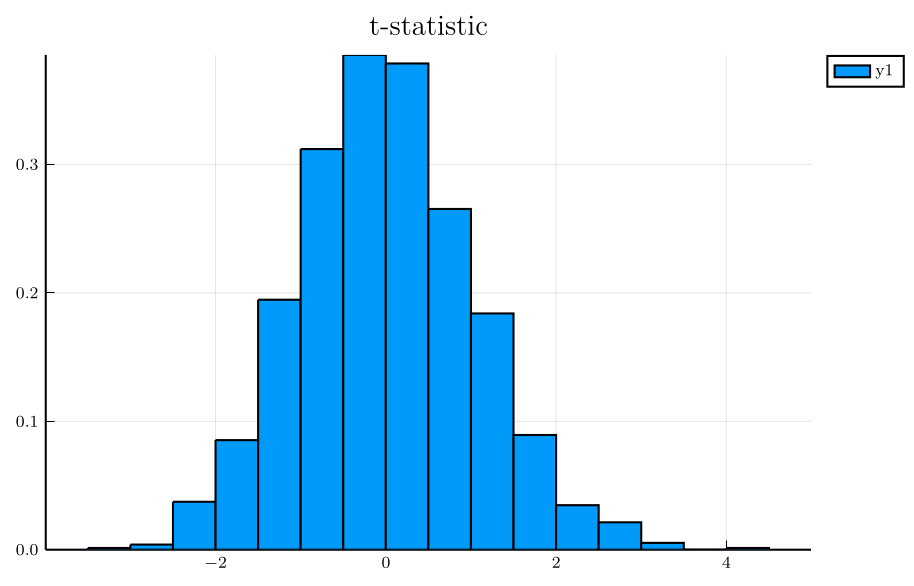

In [39]:
pgfplotsx()
histogram(real(t_statistic[:,1]),normalize = :pdf,title="t-statistic")

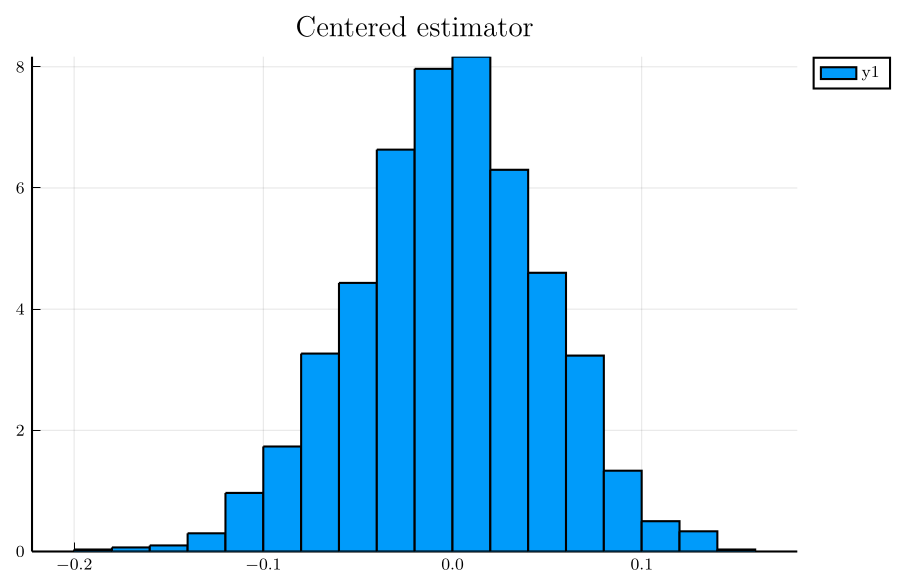

In [30]:
histogram(point_estimator.-Dhat(M2,q,1,1),normalize = :pdf,title="Centered estimator")

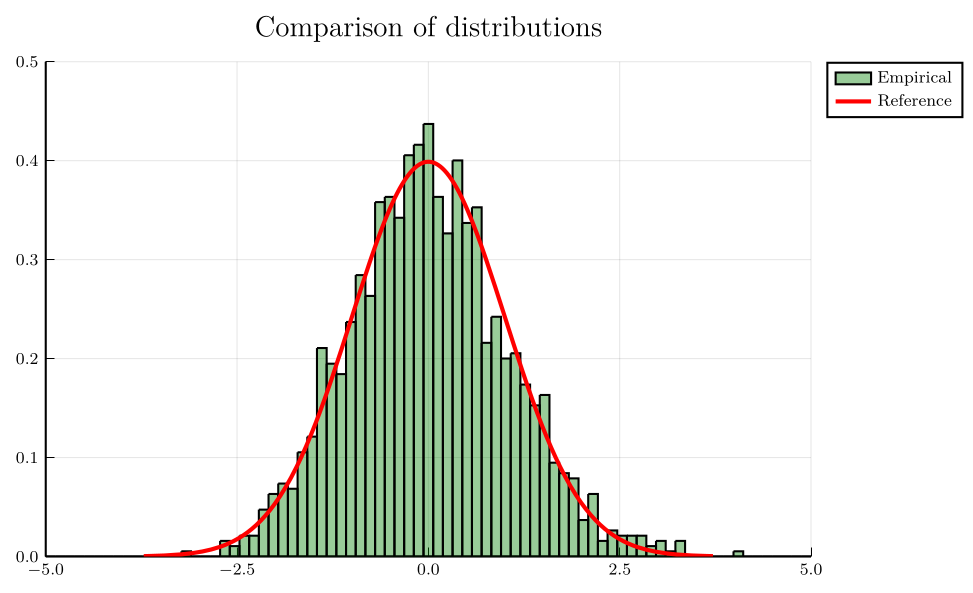

In [40]:
dens(x) = 1/sqrt(2pi) * exp(-x^2/2)
b_range = range(-5, 5, length=80)

histogram(real(t_statistic[:,1]), label="Empirical", bins=b_range, normalize=:pdf, color=:green,fillalpha=0.4)
plot!(Normal(0,1), label="Reference", lw=2, color=:red,title="Comparison of distributions")
xlims!(-5, 5)
ylims!(0, .5)

In [46]:
savefig("t_sta.svg")

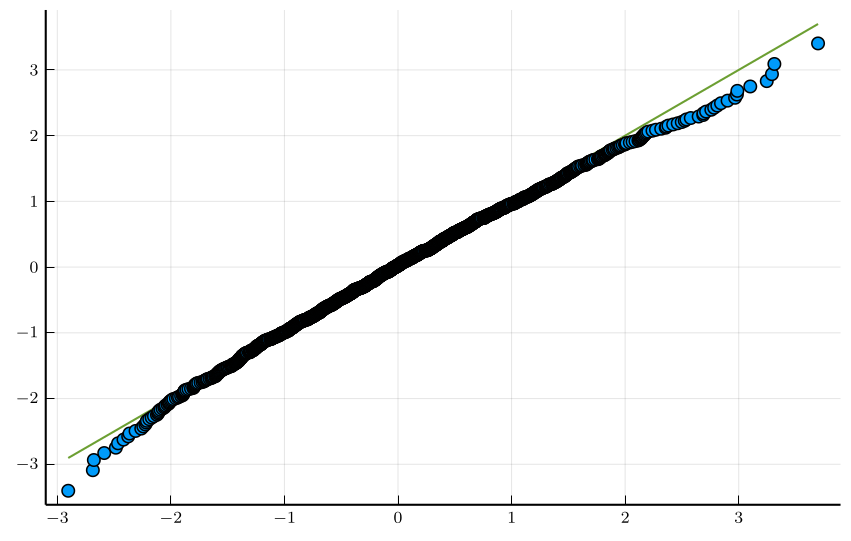

In [32]:
qqplot(real(t_statistic[:,1]),Normal(0,1))

In [56]:
savefig("qqt.tex")
savefig("qqt.pdf")
savefig("qqt.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/qqt.svg"

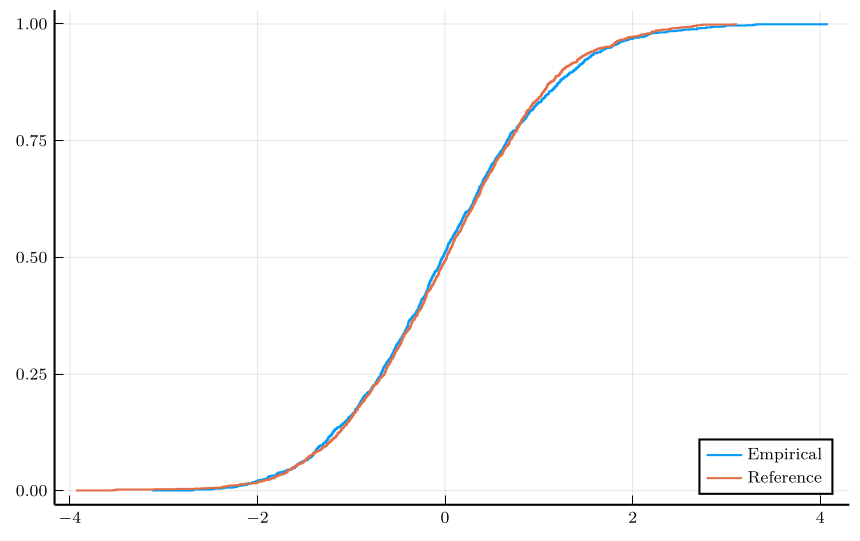

In [33]:
using StatsBase
scatter(ecdf(real(t_statistic[:,1])),label="Empirical")
scatter!(ecdf(reference),label="Reference",legend=:bottomright)

In [50]:
savefig("cdft.pdf")
savefig("cdft.svg")

In [36]:
rejections = abs.(real(t_statistic[:,1])) .> quantile(Normal(0,1),.975);
mean(rejections)

0.056